## Analysis of the labels from Google Cloud

In [1]:
from google.cloud import firestore
from google.cloud import storage
from tqdm import tqdm
from pathlib import Path
import json 
from geopy import distance
from collections import Counter
import geopandas
import pandas as pd
import numpy as np
import contextily as cx
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# new library
import reverse_geocoder as rg

#### Initialize Connection to gcloud

In [2]:
# Initialize connections to cloud storage and database
client = storage.Client()
db = firestore.Client()
gcloud_labeling_bucket = 'street2sat-gcloud-labeling'
coll = db.collection("street2sat")

#### Obtain all jsonl files

In [3]:
jsonl_blobs = [file for file in client.list_blobs(gcloud_labeling_bucket) if file.name.endswith(".jsonl")]

print(f"Found {len(jsonl_blobs)} jsonl files in the bucket.")

Found 2 jsonl files in the bucket.


Iterates through the jsonl files and creates two dataframes: one with all the images, and another with all the bounding boxes using the path as a foreign key to correspond to the image dataframe. 

In [4]:
def load_country_info(blobs: list):
    images = []
    locations = []
    bounding_boxes = []
    for blob in blobs:
        str_rep = blob.download_as_string()
        for image_labels in tqdm(str_rep.splitlines()):
            # contains all the bounding box info and image path
            info_image = json.loads(image_labels)
            image_path = info_image['imageGcsUri']
            bounding_box_info = info_image['boundingBoxAnnotations']
            for b in bounding_box_info: 
                b['path'] = image_path
            # obtain image location from database and convert to tuple
            query = coll.where("input_img", "==", image_path).limit(1).get()
            loc = query[0].to_dict()['coord']
            loc = tuple(loc)
            if (loc[0] == None or loc[1] == None):
                # dont add image if no location is available 
                continue 
            locations.append(loc)
            images.append(image_path)
            bounding_boxes.extend(bounding_box_info)
    results = rg.search(locations)
    assert len(results) == len(images), "Number of locations found is != to number of images."
    df = pd.DataFrame(results)
    df['path'] = images
    df_bounding_boxes = pd.DataFrame(bounding_boxes)
    return df, df_bounding_boxes

image_info_df,bounding_box_df = load_country_info(jsonl_blobs)

100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


Loading formatted geocoded file...


In [5]:
image_info_df.head()

,lat,lon,name,admin1,admin2,cc,path
0,43.28414,-92.81103,Osage,Iowa,Mitchell County,US,gs://street2sat-uploaded/USA/2021-08-20-cropto...
1,0.35583,32.66722,Bweyogerere,Central Region,Wakiso District,UG,gs://street2sat-uploaded/Uganda/2021-06-17_NAC...
2,0.35583,32.66722,Bweyogerere,Central Region,Wakiso District,UG,gs://street2sat-uploaded/Uganda/2021-06-17_NAC...
3,2.63422,32.00106,Nwoya,Northern Region,Nwoya District,UG,gs://street2sat-uploaded/Uganda/2021-06-29_Olw...
4,2.63422,32.00106,Nwoya,Northern Region,Nwoya District,UG,gs://street2sat-uploaded/Uganda/2021-06-29_Olw...


In [6]:
bounding_box_df.head()

,displayName,xMin,xMax,yMin,yMax,annotationResourceLabels,path
0,maize,0.305601,0.399506,0.372119,0.809001,{'aiplatform.googleapis.com/annotation_set_nam...,gs://street2sat-uploaded/Uganda/2021-06-17_NAC...
1,maize,0.456343,0.565074,0.339188,0.788145,{'aiplatform.googleapis.com/annotation_set_nam...,gs://street2sat-uploaded/Uganda/2021-06-17_NAC...
2,maize,0.789951,0.900329,0.358946,0.989023,{'aiplatform.googleapis.com/annotation_set_nam...,gs://street2sat-uploaded/Uganda/2021-06-17_NAC...
3,maize,0.906919,0.986820,0.431394,0.727772,{'aiplatform.googleapis.com/annotation_set_nam...,gs://street2sat-uploaded/Uganda/2021-06-17_NAC...
4,maize,0.098847,0.194399,0.345774,0.818880,{'aiplatform.googleapis.com/annotation_set_nam...,gs://street2sat-uploaded/Uganda/2021-06-17_NAC...


In [7]:
vc = image_info_df['cc'].value_counts()
countries = vc.keys()
print(vc)

UG    121
KE     35
US     31
Name: cc, dtype: int64


Splits the data by each country randomly. 

In [8]:
train_set = pd.DataFrame()
val_set = pd.DataFrame()
for country in countries:
    train, test = train_test_split(image_info_df[image_info_df['cc'] == country], test_size=0.15, shuffle = True)
    train_set = train_set.append(train)
    val_set = val_set.append(test)

train_set = train_set.sample(frac = 1)
val_set = val_set.sample(frac = 1)

Helper function to visualize and analyze labels

In [9]:
def labels_info(labels_df, bb_dataframe):
    comb_df = pd.merge(labels_df, bb_dataframe, how = 'inner', on = 'path')
    print('{} images found.'.format(len(labels_df)))
    print('{} labels found.'.format(len(comb_df)))
    print(comb_df['displayName'].value_counts())

    gdf = geopandas.GeoDataFrame(comb_df, geometry=geopandas.points_from_xy(comb_df.lon, comb_df.lat, crs='EPSG:4326'))
    
    ax = gdf.to_crs('EPSG:3857').plot(
        figsize=(10, 30), 
        marker='o', 
        column='displayName', 
        categorical=True,
        markersize=15,
        cmap = 'tab10',
        legend=True
    )
    ax.set_title("Label Locations")
    return cx.add_basemap(ax, source = cx.providers.OpenStreetMap.Mapnik)

    

# labels_info(train_set)


### Visualize labels
The labels can be visualized by using the helper function above. Either the train_set or val_set can be filtered by country. Use the cc parameter as shown below and use 'KE' for Kenya, 'UG' for Uganda, or 'US' for USA. 

102 images found.
211 labels found.
maize        156
banana        37
cassava        7
coffee         4
sugarcane      4
rice           3
Name: displayName, dtype: int64


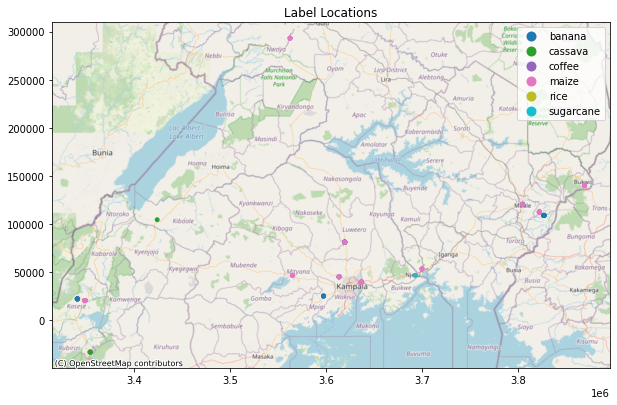

In [10]:
labels_info(train_set[train_set['cc'] == 'UG'], bounding_box_df)